## Initial Setup

In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPooling1D, Flatten, Conv1D, Dropout, Activation
from keras.preprocessing.text import Tokenizer

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import re
import string

Using TensorFlow backend.


## Training Parameters


In [2]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 128 # Number of examples used in each iteration
    EPOCHS = 2 # Number of passes through entire dataset
    VOCAB_SIZE = 30000 # Size of vocabulary dictionary
    MAX_LEN = 500 # Max length of review (in words)
    EMBEDDING_DIM = 40 # Dimension of word embedding vector

# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 32
    EPOCHS = 2
    VOCAB_SIZE = 20000
    MAX_LEN = 90
    EMBEDDING_DIM = 40

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


## Data


In [0]:
DS_PATH = '/data/'
LABELS = ['negative', 'positive']

train = pd.read_csv(os.path.join(DS_PATH, "train.tsv"), sep='\t')  
val = pd.read_csv(os.path.join(DS_PATH, "val.tsv"), sep='\t')  

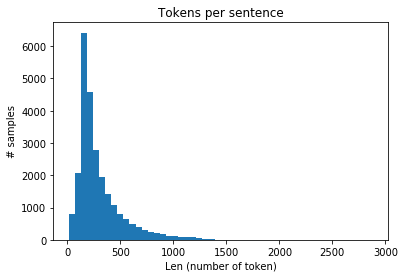

In [0]:
# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

# Plot sentence by lenght
plt.hist([len(tokenize(s)) for s in train['text'].values], bins=50)
plt.title('Tokens per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

## Data Preprocessing

In [0]:
imdb_tokenizer = Tokenizer(num_words=VOCAB_SIZE)
imdb_tokenizer.fit_on_texts(train['text'].values)

x_train_seq = imdb_tokenizer.texts_to_sequences(train['text'].values)
x_val_seq = imdb_tokenizer.texts_to_sequences(val['text'].values)

x_train = sequence.pad_sequences(x_train_seq, maxlen=MAX_LEN, padding="post", value=0)
x_val = sequence.pad_sequences(x_val_seq, maxlen=MAX_LEN, padding="post", value=0)

y_train, y_val = train['label'].values, val['label'].values

print('First sample before preprocessing: \n', train['text'].values[0], '\n')
print('First sample after preprocessing: \n', x_train[0])

First sample before preprocessing: 
 Watch the Original with the same title from 1944! This made for TV movie, is just god-awful! Although it does use (as far as I can tell) almost the same dialog, it just doesn't work! Is it the acting, the poor directing? OK so it's made for TV, but why watch a bad copy, when you can get your hands on the superb original? Especially as you'll be spoiled to the plot and won't enjoy the original as much, as if you've watched it first! <br /><br />There are a few things that are different from the original (it's shorter for once), but all are for the worse! The actors playing the parts here, just don't fit the bill! You just don't believe them and who could top Edward G. Robinsons performance from the original? If you want, only watch it after you've seen the original and even then you'll be very brave, if you watch it through! It's almost sacrilege! 

First sample after preprocessing: 
 [   5    1  111    2  525  354    1  201   14   73   14   44  871 

## Model

In [0]:
# Model Parameters

NUM_FILTERS = 250
KERNEL_SIZE = 3
HIDDEN_DIMS = 250

In [0]:
# CPU
BATCH_SIZE = 32
EPOCHS = 2
VOCAB_SIZE = 20000
MAX_LEN = 90
EMBEDDING_DIM = 40

# CNN Model
print('Build model...')
model = Sequential()


model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN))
model.add(Dropout(0.2))


model.add(Conv1D(NUM_FILTERS,
                 KERNEL_SIZE,
                 padding='valid',
                 activation='relu',
                 strides=1))


model.add(GlobalMaxPooling1D())


model.add(Dense(HIDDEN_DIMS))
model.add(Dropout(0.2))
model.add(Activation('relu'))


model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Build model...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 90, 40)            800000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 40)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 88, 250)           30250     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 250

## Train & Evaluate

In [0]:
model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.1,
          verbose=2)

score, acc = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE)
print('\nAccuracy: ', acc*100)

pred = model.predict_classes(x_val)

Train on 22500 samples, validate on 2500 samples
Epoch 1/2
 - 46s - loss: 0.4781 - acc: 0.7452 - val_loss: 0.3628 - val_acc: 0.8436
Epoch 2/2
 - 46s - loss: 0.2783 - acc: 0.8863 - val_loss: 0.3599 - val_acc: 0.8492
25000/25000 [==============================] - 5s 189us/step

Accuracy:  84.892


             precision    recall  f1-score   support

   negative       0.80      0.89      0.84     11241
   positive       0.90      0.82      0.86     13759

avg / total       0.85      0.85      0.85     25000



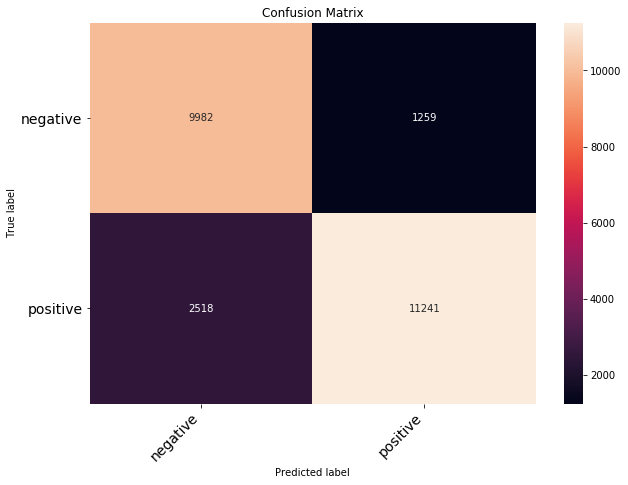

In [0]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
from support import print_confusion_matrix
cnf_matrix = confusion_matrix(pred, y_val)
_ = print_confusion_matrix(cnf_matrix, LABELS)

# Print Precision Recall F1-Score Report
from sklearn.metrics import classification_report

report = classification_report(pred, y_val, target_names=LABELS)
print(report)

In [0]:
from ipywidgets import interact_manual
from ipywidgets import widgets
import pickle

LABELS = ['negative', 'positive']

#model = keras.models.load_model("cnn_sentiment")
#with open('tokenizer.pickle', 'rb') as handle:
 #   imdb_tokenizer = pickle.load(handle)

def get_prediction(review):
    review_np_array = imdb_tokenizer.texts_to_sequences([review])
    review_np_array = sequence.pad_sequences(review_np_array, maxlen=90, padding="post", value=0)
    score = model.predict(review_np_array)[0][0]
    prediction = LABELS[model.predict_classes(review_np_array)[0][0]]
    print('REVIEW:', review, '\nPREDICTION:', prediction, '\nSCORE: ', score)

interact_manual(get_prediction, review=widgets.Textarea(placeholder='Type your Review here'));

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


interactive(children=(Textarea(value='', description='review', placeholder='Type your Review here'), Button(de…

## Save the result

In [0]:
import pickle

# Saving Tokenizer
with open('models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(imdb_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
# Saving Model Weight
model.save_weights('models/cnn_sentiment_weights.h5')